In [1]:
# -- Dependencies --
import sys
import numpy as np 
import pandas as pd 
import kwakpriv 
import pandas as pd

from w_transform import HaarTransform, InvHaarTransform
from plottingtools import _BinData, _findmin, _findmax
from plottingtools import _NewColorMap, _NSigmaFilter

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize, LogNorm
from matplotlib.colorbar import ColorbarBase
from matplotlib import cm

In [2]:
example_dir = "./examples/XYSH/"

In [3]:
File_name = example_dir + "bumpdip.csv"
File_dframe = pd.read_csv(File_name)

In [4]:
File_dframe.keys()

Index(['Mgg [GeV]', 'Nevents', 'sigma', 'hypothesis', 'generating_function'], dtype='object')

In [5]:
Nevents = np.asarray(File_dframe['Nevents'].values, dtype=int) # The number of events must be integer-type
Hypothesis = np.asarray(File_dframe['hypothesis'].values, dtype=float)
GeneratingFunction = np.asarray(File_dframe['generating_function'].values, dtype=float)
MggValues = np.asarray(File_dframe['Mgg [GeV]'].values, dtype=int)

# Optional:
# Separate the "Signal" region (first 64 bins) from the "overflow" region (last 64 bins).
Nbins = 64 

data_signal = Nevents[:Nbins]
data_overflow = np.sum(Nevents[Nbins:])

hypo_signal = Hypothesis[:Nbins]
hypo_overflow = np.sum(Hypothesis[Nbins:])

genfunc_signal = GeneratingFunction[:Nbins]
genfunc_overflow = np.sum(GeneratingFunction[Nbins:])

MggValues_signal = MggValues[:Nbins]
MggValues_overflow = np.sum(MggValues[Nbins:])


In [6]:
Output_dir=None
extr_nsets = kwakpriv.nsets(data_signal, hypo_signal, nsets=1*10**4,
                        seed=123,
                        extrapolate=False,
                        fastGaussian=False,
                        outputdir=Output_dir)

In [7]:
Level = extr_nsets.Level
Histogram = extr_nsets.Histogram
Nsigma = extr_nsets.Nsigma 
NsigmaFixedRes = extr_nsets.NsigmaFixedRes

# If fastGaussian is False
#PlessX = extr_nsets.PlessX 
#PeqX = extr_nsets.PeqX

# If fastGaussian is False AND extrapolate is true
#Nsigma_fit = extr_nsets.Nsigma_fit
#PlessX_fit = extr_nsets.PlessX_fit
#PeqX_fit = extr_nsets.PeqX_fit
#NsigmaFixedRes_fit = extr_nsets.NsigmaFixedRes_fit

In [8]:
def Fig4_narrow(nsigma_percent=1):
    data = data_signal 
    hypothesis = hypo_signal
    nsigma = Nsigma
    generating_function = genfunc_signal
    nsigma_min = None
    nsigma_colorcode=False
    title="BumpDip"
    titlesize=18
    xlabel=None
    textsize=15
    figsize=(7,9)
    ticksize=14
    labelpos=-.14
    ypad=.3
    outputfile='Fig4_BumpDip'
    
    data_color='#0782B0'
    nsigma_color='#54B959'
    
    nsigCcoeffs = nsigma
    Level = len(nsigCcoeffs)-1

    data_hist, _, data_center, data_width = _BinData(data, bins=2**(Level))
    back_hist, _, back_center, back_width = _BinData(hypothesis, bins=2**(Level))

    cut = str(nsigma_percent*100) + '%'

    DeltaCoeff = _NSigmaFilter(data, hypothesis, nsigma, nsigma_min, nsigma_percent)
    
    ReconstructedData = InvHaarTransform(DeltaCoeff, normalize=False)
    RecData = ReconstructedData

    nrows = Level+2
    ratio = [1.5]
    ratio += [1]*(Level+1)
    
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(ncols=1, nrows=nrows,
                           height_ratios=ratio,
                           hspace=0)
    axs = [fig.add_subplot(gs[i,0]) for i in range(nrows)]
    
    # Fill out top panel
    axs[0].bar(data_center, data_hist, align='center',
               width=data_width, color=data_color, label="Data")
    axs[0].tick_params(axis='y', bottom=False, labelbottom=False, labelsize=ticksize)
    axs[0].tick_params(axis='x', labelbottom=False)
    axs[0].legend(edgecolor="black", fancybox=False, fontsize=14,
                  handlelength=0.0, handletextpad=0.0)
    axs[0].set_yscale('log')
    
    # ----- NEW : 09-22-2019 -----------------------------------------------------------
    # added injected signal to the second panel 
    injected_signal = data-hypothesis
    InjData = np.divide(injected_signal, np.sqrt(hypothesis))
    inj_hist, _, inj_center, inj_width = _BinData(InjData, bins=2**Level)
    axs[1].plot(inj_center, inj_hist, 'd', markersize=4, 
                color='#539C3C', 
                label='Injected Signal')
    # ----------------------------------------------------------------------------------

    generating_function = np.divide(generating_function, np.sqrt(hypothesis))
    signal_hist, _, signal_center, signal_width = _BinData(generating_function, bins=2**(Level))
    #axs[1].plot(signal_center, signal_hist, color='red', label="Generating Function")
    
    RecData = np.divide(RecData, np.sqrt(hypothesis))
    axs[1].plot(data_center, RecData, 'o', markersize=3, color='#E67E22', label='Rec. Signal ({})'.format(cut))
    min_y_lim = min(min(RecData), min(InjData))-1.0  # NEW
    max_y_lim = max(max(RecData), max(InjData))+1.0  # NEW
    axs[1].set_ylim(bottom=min_y_lim, top=max_y_lim)  # NEW
    axs[1].tick_params(axis='y', bottom=False, labelbottom=False, labelsize=ticksize)
    axs[1].tick_params(axis='x', labelbottom=False)
    axs[1].plot(range(len(data_center)), np.zeros_like(RecData), color='black', linewidth=0.5)
    axs[1].set_yscale('linear')
    axs[1].legend(edgecolor="black", fancybox=False, fontsize=14,
                 handletextpad=0.0, handlelength=1, markerscale=1)
    
    coeffs_min = _findmin(nsigma[:Level]) # Use to set the min ylim of the plots
    coeffs_max = _findmax(nsigma[:Level]) # Use to set the max ylim of the plots

    cmap = _NewColorMap()
    sig_max = _findmax(np.absolute(nsigma[:Level]))
    norm = Normalize(vmin=0, vmax=sig_max)
    
    for l in range(Level):
        bins = 2**(Level-l-1)
        hist, edges, center, width = _BinData(nsigma[l], bins=bins)
        midLeft = (center-edges[:-1])/2.0
        LeftCenter = edges[:-1]+midLeft
        midRight = (edges[1:]-center)/2.0
        RightCenter = center+midRight
        
        norm_points = norm(np.absolute(nsigma[l]))
        color_points = [cmap(i) for i in norm_points]
        axs[l+2].bar(LeftCenter, hist, align='center', width=width/2.0,
                     color=color_points)
        axs[l+2].bar(RightCenter, hist, align='center', width=width/2.0,
                     color=color_points, alpha=0.8)
        
        axs[l+2].set_ylim(coeffs_min-ypad, coeffs_max+ypad)
        #axs[l+2].plot(range(bins), np.zeros(bins), color='black', linewidth=0.5)
        axs[l+2].plot(edges, np.zeros_like(edges), color='black', linewidth=0.5)
        axs[l+2].tick_params(axis='y', bottom=False, labelbottom=False, labelsize=ticksize)
        axs[l+2].tick_params(axis='x', labelbottom=False)
        lev = Level-l-1
        axs[l+2].text(x=labelpos, y=.66, s=r'$\ell={%.1i}$'%(lev+1), fontsize=textsize,
                      #bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 5},
                      transform=axs[l+2].transAxes,
                      rotation=90)
        
    axs[-1].tick_params(axis='x', labelbottom=True, labelsize=ticksize, pad=10)
    
    ticks=np.linspace(edges[0], edges[-1], 2**(Level-1))
    major_ticks=[]
    minor_ticks=[]
    for i, tick in enumerate(ticks):
        if i%4==0:
            major_ticks.append(tick)
        else:
            minor_ticks.append(tick)
        
    axs[-1].set_xticks(major_ticks)
    axs[-1].tick_params(axis='x', which='major', length=8)
    
    axs[-1].set_xticks(minor_ticks, minor=True)
    axs[-1].tick_params(axis='x', which='minor', length=5)
    
    labels = []
    for i, lab in enumerate(MggValues_signal):
        if i%8==0:
            labels.append(MggValues_signal[i])
    axs[-1].set_xticklabels(labels=labels)
    
    fig.text(x=0.46, y=.050, s=r'$[GeV]$', fontsize=textsize)
        
    cbar_axs = fig.add_axes([0.93, 0.15, 0.02, 0.7]) # colorbar axis
    cbar_axs.tick_params(axis='y', labelsize=ticksize)
    cbar = ColorbarBase(cbar_axs, cmap=cmap, norm=norm)
    
    fig.text(x=0.93, y=.86, s=r'$N\sigma$', fontsize=textsize)
        
    fig.suptitle(title, fontsize=titlesize, y=0.92)
    fig.text(x=0.5, y=0.1, s=xlabel, fontsize=textsize)
        
    plt.savefig(outputfile, bbox_inches='tight', format='pdf')
    plt.show()
        

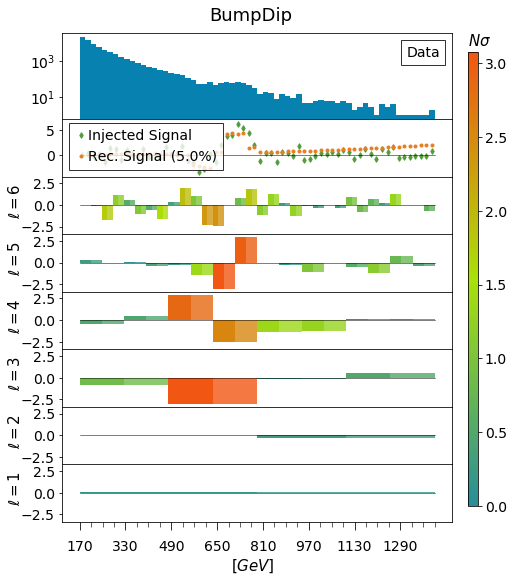

In [9]:
r_percent = 5
Fig4_narrow(nsigma_percent=r_percent*0.01)